In [6]:
!pip install mpi4py

     |████████████████████████████████| 1.4MB 21.5MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp37-cp37m-linux_x86_64.whl size=2065197 sha256=5e896cacf90aad1beb00cccb22b256eaed857f55f3f086f8d61426d6d38125d3
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py


In [1]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 72kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=8d2bc0675d2e88c40ed3ef3cab2fcea797dda89e1dfe3fbd2f8ccdaa569a10da
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [9]:
import time
import matplotlib.pyplot as plt
import imageio as ig
import numpy as np
import os
from moviepy.editor import ImageSequenceClip
from PIL import Image, ImageSequence

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3694592/45929032 bytes (8.0%)7757824/45929032 bytes (16.9%)11337728/45929032 bytes (24.7%)15138816/45929032 bytes (33.0%)19300352/45929032 bytes (42.0%)23232512/45929032 bytes (50.6%)27238400/45929032 bytes (59.3%)31432704/45929032 bytes (68.4%)35225600/45929032 bytes (76.7%)39084032/45929032 bytes (85.1%)43130880/45929032 bytes (93.9%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [12]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/3001 proj")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
def oil_effect(color_img, width_range, height_range, radius=3, level=10, gap=1):
    '''
    :param color_img: 4d array of images
    :param width_range: range of width to filter
    :param height_range: range of height to filter
    :param radius: convolution radius for each pixel
    :param level: level of intensity
    :param gap: skip pixel
    :return: 2d array after oil painting effect
    '''
    page, height, weight, channel = color_img.shape
    des_img = np.copy(color_img)
    for z in range(page):
        img = color_img[z]
        for i in range(height_range[0] + radius, height_range[1] - radius, gap):
            for j in range(width_range[0] + radius, width_range[1] - radius, gap):

                # store number of each gray level of pixel
                level_counter = np.zeros(level)
                b_level = np.zeros(level)
                r_level = np.zeros(level)
                g_level = np.zeros(level)

                for m in range(-radius, radius):
                    for n in range(-radius, radius):
                        b, g, r, o = img[i+m, j+n]
                        avg = (int(b)+int(g)+int(r)) / 3.
                        pixlv = int(avg / (256 / level))
                        level_counter[pixlv] += 1
                        b_level[pixlv] += b
                        g_level[pixlv] += g
                        r_level[pixlv] += r

                most_level_count = np.max(level_counter)
                most_level_Idx = np.argmax(level_counter)

                des_img[z, i, j, 0] = b_level[most_level_Idx] / most_level_count
                des_img[z, i, j, 1] = g_level[most_level_Idx] / most_level_count
                des_img[z, i, j, 2] = r_level[most_level_Idx] / most_level_count

    return des_img

In [37]:
start = time.time()
gif_read = ig.get_reader("/content/drive/My Drive/Colab Notebooks/3001 proj/girl.gif")
gif = np.array([i for i in gif_read])     #gif:4d
p, h, w, c = gif.shape
#res = oil_effect(gif, [w//4, w//2], [h//4, h*3//4])
res = oil_effect(gif, [50,200], [50,100])
print("total time:{}".format(time.time()-start))

total time:54.55492663383484


In [42]:
des_img.shape

(39, 250, 262, 4)

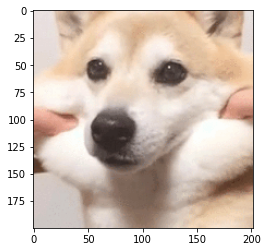

In [43]:
plt.imshow(gif[21])
plt.show()

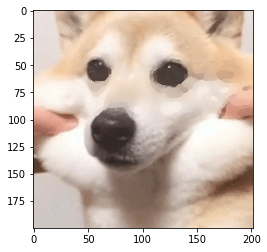

In [44]:
plt.imshow(res[21])
plt.show()

In [22]:
# output each frame as jpg
# https://stackoverflow.com/questions/11837979/removing-white-space-around-a-saved-image-in-matplotlib
def jpg_output(gif):
    f,y,x,c = gif.shape
    for i in range(f):
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.imshow(gif[i])
        plt.savefig('./frames/frame_{}.jpg'.format(i), bbox_inches = 'tight', pad_inches = 0)

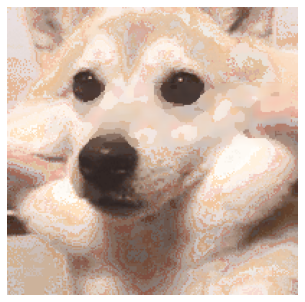

In [45]:
jpg_output(res)

In [24]:
# imageio doc: https://imageio.readthedocs.io/en/stable/examples.html
# combine jpgs to gif
def output_gif(frames_path, gif_path, gif):
    f = gif.shape[0]
    with ig.get_writer(gif_path, mode='I') as writer:
        for i in range(f):
            writer.append_data(ig.imread(frames_path.format(i=i)))

In [46]:
gif_path = "./outputs/dog_trans.gif"
frames_path = "./frames/frame_{i}.jpg"

output_gif(frames_path,gif_path,res)

In [35]:
#%%writefile temp.py
import numpy as np
from mpi4py import MPI
import face_recognition
import os
from PIL import Image
import cv2
import time
from itertools import product
from matplotlib import image
from matplotlib import pyplot as plt

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
dest = 0
path = os.getcwd()
ts = time.time()
# set up parameters


gif_read = ig.get_reader("/content/drive/My Drive/Colab Notebooks/3001 proj/dog.gif")
color_img = np.array([i for i in gif_read]) 
p, h, w, c = color_img.shape

page, height, weight, channel = color_img.shape
des_img = np.copy(color_img)
gap = 1
radius = 3
level = 10
for z in range(page):
    if rank == 0:
        # read the image
        #image = face_recognition.load_image_file(path + "/data/worlds-largest-selfie.jpg").astype('float64')
        #image = face_recognition.load_image_file("/content/drive/My Drive/Colab Notebooks/3001 proj/frames/frame_50.jpg").astype('float64')
        image = color_img[z]
        outputData = np.zeros(image.shape, dtype='float64')
        height, width, color = image.shape
        split = np.array_split(image,size,axis = 0)
        split_sizes = []

        for i in range(0,len(split),1):
            split_sizes = np.append(split_sizes, len(split[i]))
        split_sizes_input = split_sizes*width*color
        displacements_input = np.insert(np.cumsum(split_sizes_input),0,0)[0:-1]

        split_sizes_output = split_sizes*width*color
        displacements_output = np.insert(np.cumsum(split_sizes_output),0,0)[0:-1]

        print("Input data split into vectors of sizes %s" %split_sizes_input)
        print("Input data split with displacements of %s" %displacements_input)
    else:
        split_sizes_input = None
        displacements_input = None
        split_sizes_output = None
        displacements_output = None
        split = None
        image = None
        outputData = None
        width = None

    split = comm.bcast(split, root=0) #Broadcast split array to other cores
    split_sizes = comm.bcast(split_sizes_input, root = 0)
    displacements = comm.bcast(displacements_input, root = 0)
    split_sizes_output = comm.bcast(split_sizes_output, root = 0)
    displacements_output = comm.bcast(displacements_output, root = 0)
    width = comm.bcast(width, root=0)
    output_chunk = np.zeros(np.shape(split[rank])) #Create array to receive subset of data on each core, where rank specifies the core
    # print("Rank %d with output_chunk shape %s" %(rank,output_chunk.shape))

    comm.Scatterv([image,split_sizes_input, displacements_input,MPI.DOUBLE], output_chunk, root=0)

    output = np.zeros([len(output_chunk),width, 3]) #Create output array on each core

    for i in range(0,np.shape(output_chunk)[0],1):  des_img[z, i, j, 0] = b_level[most_level_Idx] / most_level_count
        # print(i)
        # print(output_chunk[i].shape)
        output[i,0:width, 0:3] = output_chunk[i]
    # print(f"rank {rank} with output {output[0:5]}")
    comm.Barrier()
    output = output.astype(np.uint8)

    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    img_rgb = output[:, :, ::-1]

    # image = face_recognition.load_image_file(path + f"/{rank}.png")
    face_locations = face_recognition.face_locations(img_rgb, model='knn')
    print(f"rank {rank} with {len(face_locations)} faces detected!")

    for face in face_locations:
        top, right, bottom, left = face
        for i in range(top + radius, bottom - radius, gap):
            for j in range(left + radius, right - radius, gap):

                # store number of each gray level of pixel
                level_counter = np.zeros(level)
                b_level = np.zeros(level)
                r_level = np.zeros(level)
                g_level = np.zeros(level)

                for m in range(-radius, radius):
                    for n in range(-radius, radius):
                        b, g, r, o = img[i+m, j+n]
                        avg = (int(b)+int(g)+int(r)) / 3.
                        pixlv = int(avg / (256 / level))
                        level_counter[pixlv] += 1
                        b_level[pixlv] += b
                        g_level[pixlv] += g
                        r_level[pixlv] += r

                most_level_count = np.max(level_counter)
                most_level_Idx = np.argmax(level_counter)

                des_img[z, i, j, 0] = b_level[most_level_Idx] / most_level_count
                des_img[z, i, j, 1] = g_level[most_level_Idx] / most_level_count
                des_img[z, i, j, 2] = r_level[most_level_Idx] / most_level_count





#plt.gca().set_axis_off()
#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
#plt.margins(0,0)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.imshow(image_output)
#plt.savefig('./output_{}.jpg'.format(rank), bbox_inches = 'tight', pad_inches = 0)

print(time.time() - ts)

# if rank == 0:
#     outputData = outputData[0:len(test),:]
#     print("Final data shape %s" %(outputData.shape,))
#     plt.imshow(outputData)
#     plt.colorbar()
#     plt.show()
#     print(outputData)

Input data split into vectors of sizes [262000.]
Input data split with displacements of [0.]


ValueError: ignored

In [ ]:
jpg_output(des_img)

In [ ]:
gif_path = "./outputs/dog_trans.gif"
frames_path = "./frames/frame_{i}.jpg"

output_gif(frames_path,gif_path,des_img)

In [16]:
img_rgb.shape

(288, 290, 3)

In [41]:
a = face_recognition.load_image_file("/content/drive/My Drive/Colab Notebooks/3001 proj/frames/frame_0.jpg").astype('float64')
a.shape

(288, 301, 3)

In [47]:
res.shape

(51, 200, 202, 4)

In [ ]:
#!mpirun --allow-run-as-root -n 5 temp.py